In [1]:
%matplotlib widget

In [2]:
import numpy as np
import pandas as pd
from matplotlib import cm, text, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import re


In [3]:
eti='Ea'

In [4]:
result_files = glob.glob("results_{}_wci/*.csv".format(eti))

In [5]:
#result_files = glob.glob("Deprecated/*.csv")

In [6]:
def get_interval_mean(interval_str):
  # Use regular expression to extract numbers
  match = re.search(r"\(([^,]+),([^,]+)\]", interval_str)
  if match:
    # Extract matched groups as floats and calculate mean
    start, end = map(float, match.groups())
    mean = (start + end) / 2
    return mean
  else:
    # Handle invalid interval string (optional)
    raise ValueError("Invalid interval format")

In [7]:
# Dictionary for covariate name english
covar_dict = {"edat": "Age", "any": "Surgery year", "bmi": "BMI", "charlindex": "Charlson index", "codisexe": "Sex", "nivah": "Hospital category",
              "Diabetes": "Diabetes", "Obesitat": "Obesity", "Rheumatoid": "Rheumatoid arthritis", "smoking": "Smoking status", 
              "Durada": "Surgery duration", "viscositat": "Viscosity", "Alcohol": "Alcohol abuse"}

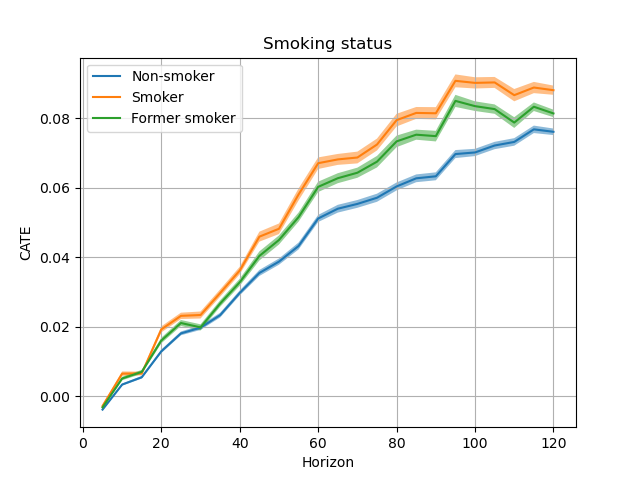

here


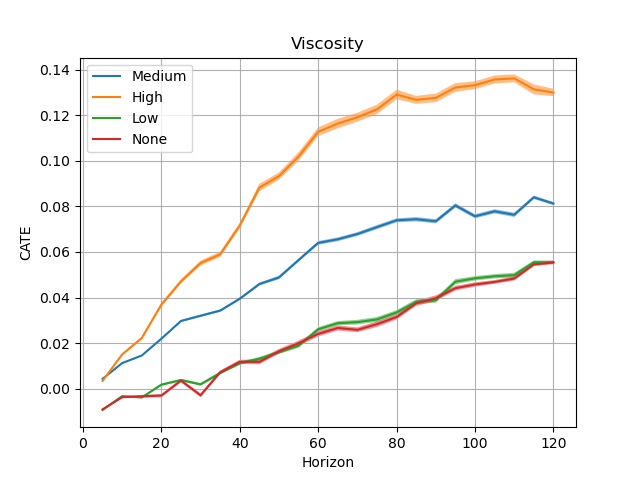

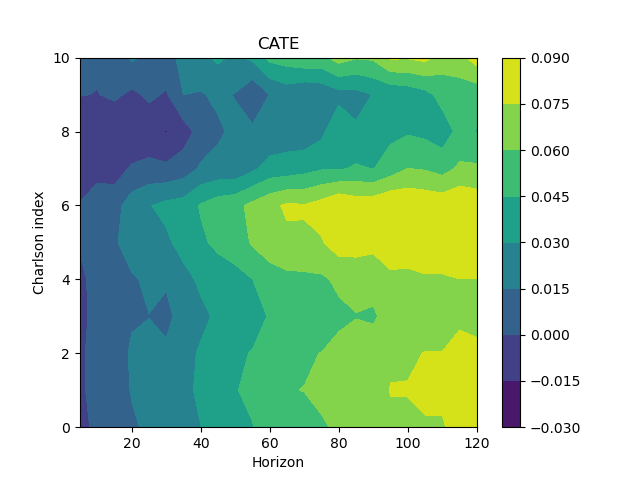

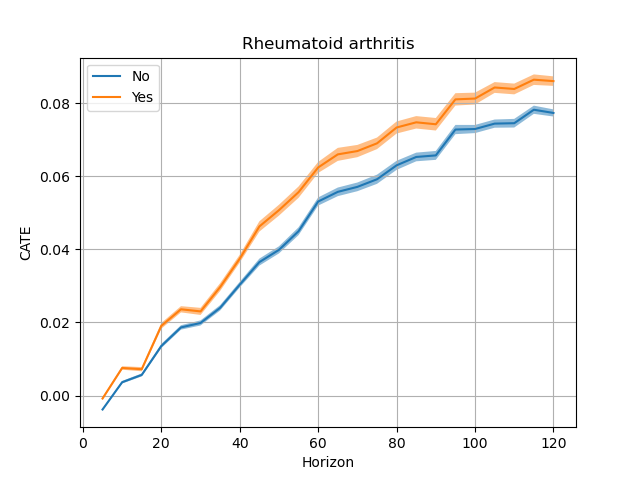

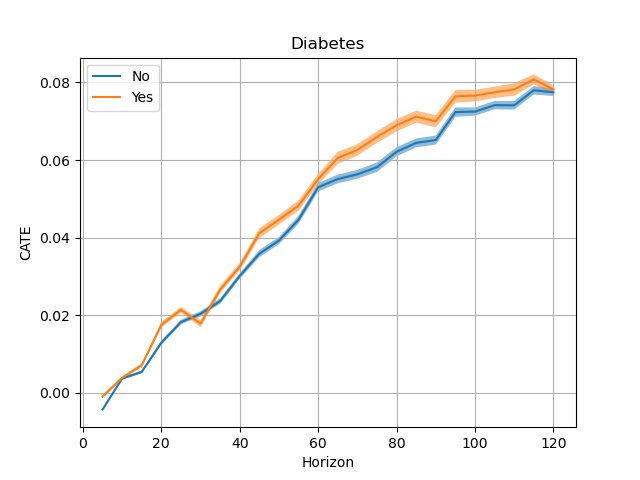

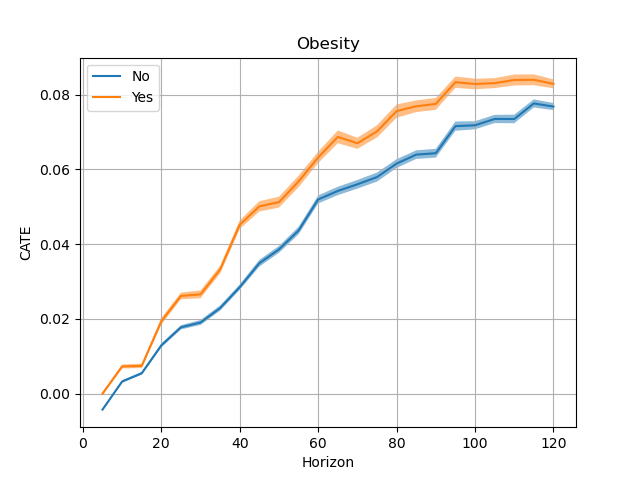

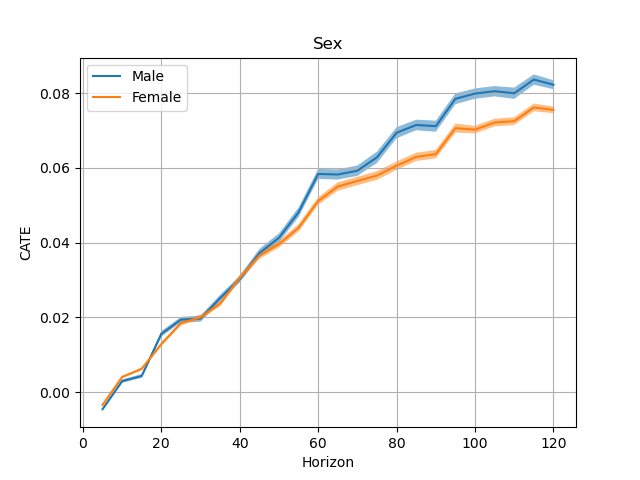

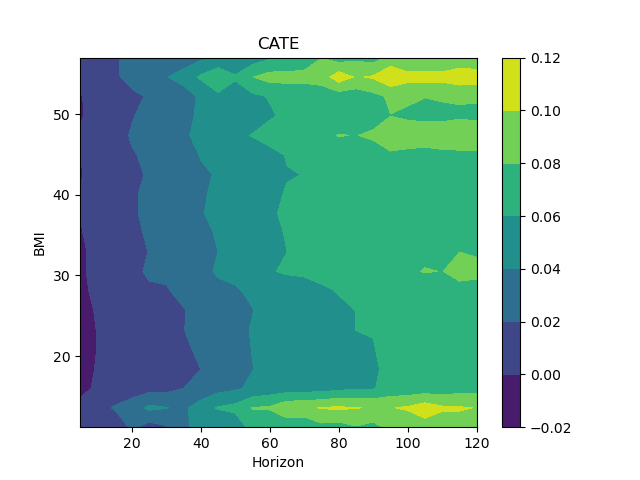

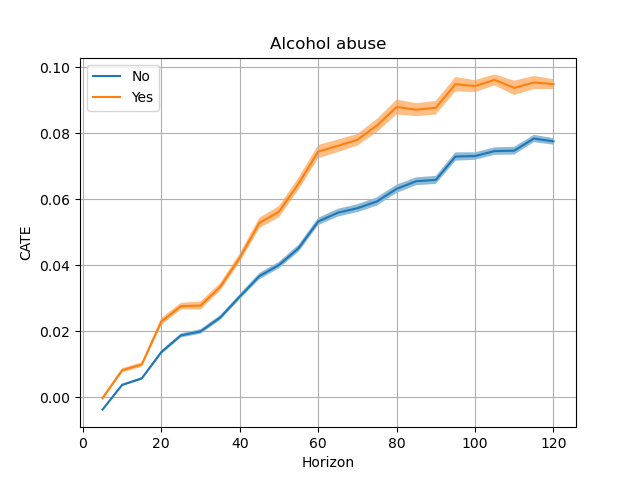

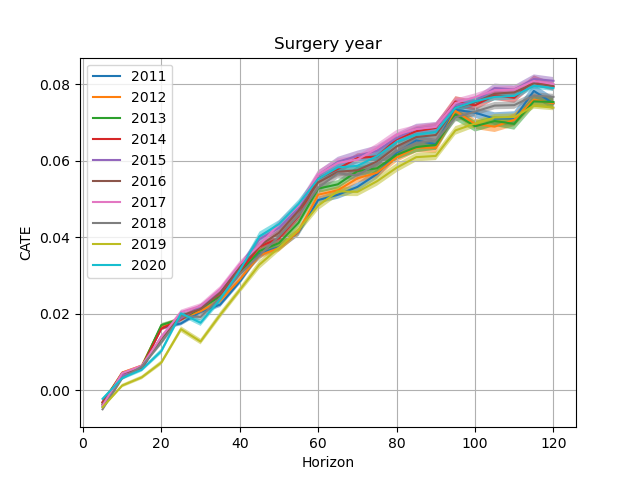

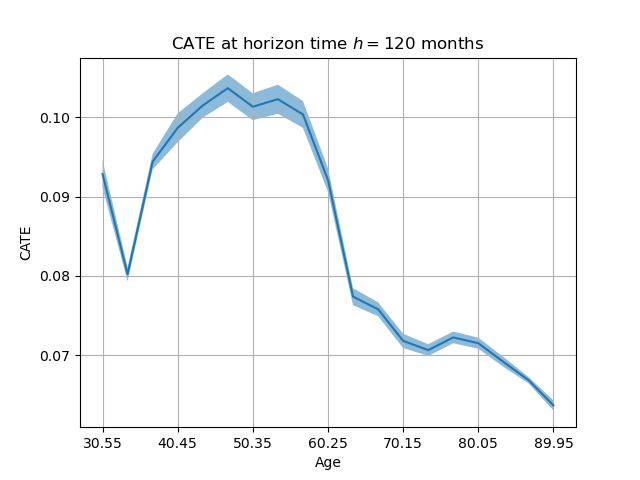

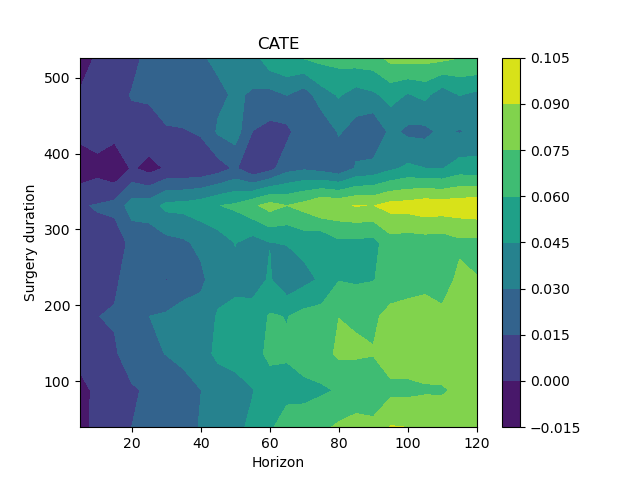

here


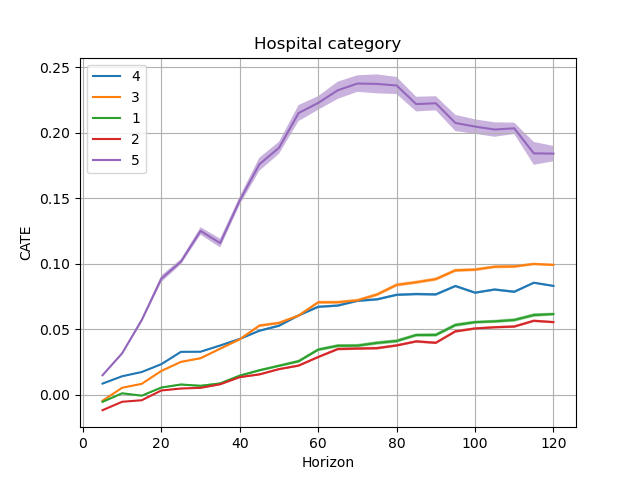

In [8]:
for _,file in enumerate(result_files):
  covar = file.split('_')[4]
  data = pd.read_csv(file)
  
  continuous_covars = ['bmi', 'charlindex', 'any_qx', 'Durada']
  
  if covar in continuous_covars:
    
    X = pd.to_numeric(data.columns.values[2:])
    Y = data['0'].values
    if isinstance(Y[0], str):
      Y = [get_interval_mean(y_i) for y_i in Y]
    X, Y = np.meshgrid(X, Y)
    Z = data.loc[:,data.columns[2:]].applymap(lambda x: x.split(';')[0],).values

    #X = pd.to_numeric(data.columns.values[2:])
    #Y = data['0'].values
    #if isinstance(Y[0], str):
    #  Y = [get_interval_mean(y_i) for y_i in Y]
    #X, Y = np.meshgrid(X, Y)
    #Z = data.loc[:,data.columns[2:]].values
    #print(Z)
    
    #####################################
    ## Plot the surface with a colormap
    #fig = plt.figure(figsize=(20,16))
    #ax = fig.add_subplot(111, projection='3d')
    #surf = ax.plot_trisurf(X.flatten(), Y.flatten(), Z.flatten(), cmap=cm.coolwarm, linewidth=0.1, edgecolor='none')
    #
    ## Set labels and title
    #ax.set_xlabel('Horizon')
    #ax.set_ylabel(covar)
    #ax.set_zlabel('ATE')
    #ax.set_title('{} - Horizon ATE'.format(covar))
    ######################################
    
    ####################################
    # Plot 2D contour
    # Plot the surface with a colormap
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.contourf(X, Y, Z, cmap=cm.coolwarm)
    plt.colorbar(plt.contourf(X, Y, Z))
    
    # Set labels and title
    ax.set_xlabel('Horizon')
    ax.set_ylabel(covar_dict[covar])
    ax.set_title('CATE')
    
    if covar=='edat':
      print('here')
      ax.set_ylim((Y[0][0], 90))
    ######################################
    
    plt.show()
    plt.savefig('results_{}_wci/{}_surface.pdf'.format(eti, covar))
    plt.close()
    
  elif covar=='edat':
    # Read data for the plot
    ate = pd.to_numeric(data.loc[:,data.columns[-1]].apply(lambda x: x.split(';')[0],).values)
    ate_std = pd.to_numeric(data.loc[:,data.columns[-1]].apply(lambda x: x.split(';')[1],).values)
    X = data['0'].values[:]
    if isinstance(X[0], str):
      X = [get_interval_mean(x_i) for x_i in X]
    
    # Leave last point out, patients above 90 years
    ate = ate[0:-1]
    ate_std = ate_std[0:-1]
    X = X[0:-1]
    
    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(X, ate)
    plt.fill_between(X, ate-1.96*ate_std, ate+1.96*ate_std, alpha=0.5)
    plt.xticks(X[0::3])
    plt.grid(True)
    ax.set_xlabel('Age')
    ax.set_ylabel('CATE')
    ax.set_title('CATE at horizon time $h=$120 months')
    
    plt.show() 
    plt.savefig('results_{}_wci/age_h120.pdf'.format(eti))
    plt.close()
    
  else:
    # Read data for the plot
    ate = data.loc[:,data.columns[2:]].applymap(lambda x: x.split(';')[0],)
    ate_std = data.loc[:,data.columns[2:]].applymap(lambda x: x.split(';')[1],)
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for index, row in ate.iterrows():
      plt.plot(pd.to_numeric(ate.columns.values), pd.to_numeric(row.values), label=str(data.iloc[index,1]))
      plt.fill_between(pd.to_numeric(ate.columns.values), pd.to_numeric(row.values)-1.96*pd.to_numeric(ate_std.iloc[index].values), pd.to_numeric(row.values)+1.96*pd.to_numeric(ate_std.iloc[index].values), alpha=0.5)
    
    #data.loc[:,data.columns[2:]].T.plot(grid=True)
    #fig = plt.gcf()
    #ax = plt.gca()

    # Set labels and title
    plt.grid(True)
    ax.set_xlabel('Horizon')
    ax.set_ylabel('CATE')
    ax.set_title(covar_dict[covar])
    if covar=='nivah':
      print('here')
      ax.legend(["4",  "3",  "1",  "2",  "5"])
    elif covar=='viscositat':
      print('here')
      ax.legend(["Medium", "High",  "Low", "None"])
    elif covar=='smoking':
      ax.legend(["Non-smoker", "Smoker",  "Former smoker"])
    elif covar=='codisexe':
      ax.legend(["Male", "Female"])
    elif covar=='any':
      ax.legend(["2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020"])
    else:
      ax.legend(["No", "Yes"])

    plt.show()
    plt.savefig('results_{}_wci/{}_surface.pdf'.format(eti, covar))
    plt.close()